## Rasterize polygon features using `rasterio`
In this example, NHDPlus catchment numbers are sampled by the model grid, to determine stream segments corresponding to those catchments for routing overland flow

In [18]:
import sys
sys.path.append('/Users/aleaf/Documents/GitHub/flopy3/')
import numpy as np
import matplotlib.pyplot as plt
from rasterio import features
from rasterio import Affine
from GISops import project
from GISio import shp2df
from shapely.geometry import box, Point, mapping
from flopy.utils.reference import SpatialReference

%matplotlib inline

In [3]:
# model grid information
nrow, ncol, nlay = 817, 1228, 5
xll, yll = 617822.3, 5114820.7
dxdy = 250
dxdy_m = dxdy*.3048
rot = 0.0
model_epsg = 26715

# NHDPlus catchment files (polygons)
nhdcatchmentfiles = ['/Users/aleaf/Documents/NHDPlus/NHDPlusGL/NHDPlus04/NHDPlusCatchment/Catchment.shp',
                     '/Users/aleaf/Documents/NHDPlus/NHDPlusMS/NHDPlus07/NHDPlusCatchment/Catchment.shp']
# shapefile of SFR package tying NHDPlus Common Identifiers 
#(same as catchment numbers) to stream segment numbers
sfrlines = shp2df('../streams/br_lines.shp')


reading ../streams/br_lines.shp...
--> building dataframe... (may take a while for large shapefiles)


### make a `flopy SpatialReference` object

In [4]:
sr = SpatialReference(delr=np.ones(ncol)*dxdy, delc=np.ones(nrow)*dxdy, length_multiplier=0.3048,
                     xll=xll, yll=yll, epsg=model_epsg)

### get the bounds of the model in lat-lon for filtering the NHDPlus files
filtering can greatly speed up reading in the shapefiles that cover large areas (such as the entire Great Lakes basin), when only results from a small part of that area are needed

In [7]:
bounds_ll = project(box(*sr.bounds), '+init=epsg:{}'.format(model_epsg), '+init=epsg:4269')
bounds_ll.bounds

(-91.47368546346513, 46.15607821009628, -90.23424304911663, 46.738745374959635)

In [8]:
cat = shp2df(nhdcatchmentfiles, filter=bounds_ll.bounds)


reading /Users/aleaf/Documents/NHDPlus/NHDPlusGL/NHDPlus04/NHDPlusCatchment/Catchment.shp...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Documents/NHDPlus/NHDPlusMS/NHDPlus07/NHDPlusCatchment/Catchment.shp...
--> building dataframe... (may take a while for large shapefiles)


In [9]:
cat.head()

,GRIDCODE,FEATUREID,SOURCEFC,AreaSqKM,geometry
0,7593,1797317,NHDFlowline,0.0945,POLYGON ((-90.94107041432243 46.58289585651074...
1,7664,1797319,NHDFlowline,0.3384,POLYGON ((-90.95310659701761 46.58388263890946...
2,7740,1797311,NHDFlowline,0.0423,POLYGON ((-90.93624980508767 46.58461544660413...
3,7921,1797281,NHDFlowline,1.8981,POLYGON ((-90.82346995915817 46.59774852247784...
4,7973,1797271,NHDFlowline,1.7091,(POLYGON ((-90.74795715149614 46.6331081561438...


In [10]:
sfrlines.head()

,reachID,node,segment,reach,outseg,comid,asum,geometry
0,45776,786485,1,1,3,1816005,0.000584,LINESTRING (660874.6459550587 5128238.01559588...
1,45777,786486,1,2,3,1816005,0.036020,"LINESTRING (660875.3 5128242.365013323, 660885..."
2,45778,785258,1,3,3,1816005,0.107785,"LINESTRING (660885.1849181824 5128308.1, 66089..."
3,45779,784030,1,4,3,1816005,0.184842,LINESTRING (660896.6435158572 5128384.29999999...
4,45780,782802,1,5,3,1816005,0.261899,LINESTRING (660908.102113532 5128460.499999999...


### Map COMID numbers to SFR segments

In [11]:
# map COMID values to SFR segments
segments = dict(zip(sfrlines.comid, sfrlines.segment))

# map NHDPlus catchments to segments
cat_segments = [segments.get(comid, 0) for comid in cat.FEATUREID]

### reproject the catchments into model coordinate system (UTM)

In [13]:
cat_utm = project(cat.geometry.values, '+init=epsg:4269', '+init=epsg:26715')

# make a list of catchment features that corresponds to segment numbers list above
shapes = list(zip([mapping(g) for g in cat_utm], cat_segments))

### Make an `Affine` object to orient the model grid in space
usage is `Affine(a, b, c, d, e, f)`

where:

a = width of a pixel  
b = row rotation (typically zero)  
c = x-coordinate of the upper-left corner of the upper-left pixel  
d = column rotation (typically zero)  
e = height of a pixel (typically negative)  
f = y-coordinate of the of the upper-left corner of the upper-left pixel  

In [14]:
# Make an affine object describing the location of the model grid
trans = Affine(dxdy_m, rot, sr.xul, rot, -dxdy_m, sr.yul)
trans

Affine(76.2, 0.0, 617822.3,
       0.0, -76.2, 5177076.100000001)

### rasterize the catchments!

In [27]:
raster = features.rasterize(shapes, out_shape=(nrow, ncol),
                            transform=trans)
raster

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ..., 
       [1483, 1483, 1483, ...,    0,    0,    0],
       [   0, 1483, 1483, ...,    0,    0,    0],
       [   0, 1483, 1483, ...,    0,    0,    0]], dtype=uint16)

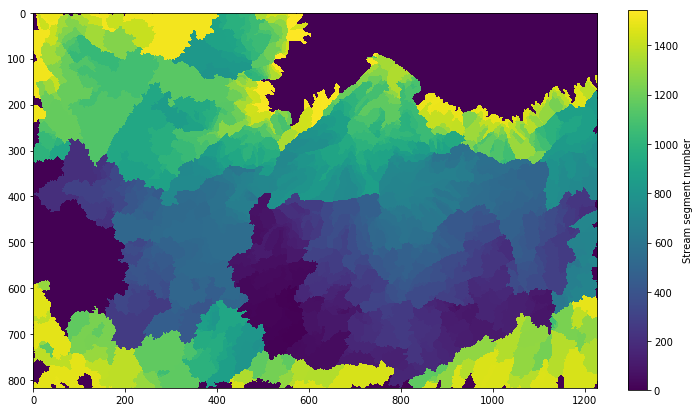

In [26]:
plt.figure(figsize=(11, 8.5))
plt.imshow(raster)
plt.colorbar(label='Stream segment number', fraction=.031)

### Write the results out to a text file
in this exampmle, this file can be used directly in the MODFLOW UZF package as the irunbnd array

In [ ]:
np.savetxt('irunbnd.dat', raster, fmt='%d')